In [0]:
#UPLOAD KAGGLE API KEY

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mikuns","key":"**************************"}'}

In [0]:
#INITIATING KAGGLE

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
#LOADING DSN DATASET 

!kaggle competitions download -c intercampusai2019

  0% 0.00/234k [00:00<?, ?B/s]
100% 234k/234k [00:00<00:00, 35.8MB/s]
  0% 0.00/242k [00:00<?, ?B/s]
100% 242k/242k [00:00<00:00, 76.8MB/s]
  0% 0.00/541k [00:00<?, ?B/s]
100% 541k/541k [00:00<00:00, 35.2MB/s]


In [0]:
#IMPORTING LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from xgboost import XGBClassifier

#CONFIG
color = sns.color_palette()
sns.set_style('darkgrid')


In [0]:
#INITIATING TRAINING AND TEST DATA

training_data = pd.read_csv("train.csv.zip")
test_data = pd.read_csv("test.csv.zip")
training_data.head().T

,0,1,2,3,4
EmployeeNo,YAK/S/00001,YAK/S/00002,YAK/S/00003,YAK/S/00004,YAK/S/00006
Division,Commercial Sales and Marketing,Customer Support and Field Operations,Commercial Sales and Marketing,Commercial Sales and Marketing,Information and Strategy
Qualification,"MSc, MBA and PhD",First Degree or HND,First Degree or HND,First Degree or HND,First Degree or HND
Gender,Female,Male,Male,Male,Male
Channel_of_Recruitment,Direct Internal process,Agency and others,Direct Internal process,Agency and others,Direct Internal process
Trainings_Attended,2,2,2,3,3
Year_of_birth,1986,1991,1987,1982,1990
Last_performance_score,12.5,12.5,7.5,2.5,7.5
Year_of_recruitment,2011,2015,2012,2009,2012
Targets_met,1,0,0,0,0


**DATA EXPLORATION**

In [0]:
print('Training Data',training_data.shape)
print('Test Data', test_data.shape)

Training Data (38312, 19)
Test Data (16496, 18)


In [0]:
training_data.describe()

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not
count,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000
mean,2.253680,1986.209334,7.698959,2013.139695,0.352996,0.023152,55.366465,0.084595
std,0.609443,7.646047,3.744135,4.261451,0.477908,0.150388,13.362741,0.278282
min,2.000000,1950.000000,0.000000,1982.000000,0.000000,0.000000,31.000000,0.000000
25%,2.000000,1982.000000,5.000000,2012.000000,0.000000,0.000000,43.000000,0.000000
50%,2.000000,1988.000000,7.500000,2014.000000,0.000000,0.000000,52.000000,0.000000
75%,2.000000,1992.000000,10.000000,2016.000000,1.000000,0.000000,68.000000,0.000000
max,11.000000,2001.000000,12.500000,2018.000000,1.000000,1.000000,91.000000,1.000000


In [0]:
test_data.isnull().any(), training_data.isnull().any()

(EmployeeNo                             False
 Division                               False
 Qualification                           True
 Gender                                 False
 Channel_of_Recruitment                 False
 Trainings_Attended                     False
 Year_of_birth                          False
 Last_performance_score                 False
 Year_of_recruitment                    False
 Targets_met                            False
 Previous_Award                         False
 Training_score_average                 False
 State_Of_Origin                        False
 Foreign_schooled                       False
 Marital_Status                         False
 Past_Disciplinary_Action               False
 Previous_IntraDepartmental_Movement    False
 No_of_previous_employers               False
 dtype: bool, EmployeeNo                             False
 Division                               False
 Qualification                           True
 Gender              

In [0]:
training_data['Qualification'].unique()

array(['MSc, MBA and PhD', 'First Degree or HND', nan,
       'Non-University Education'], dtype=object)

In [0]:
training_data['Qualification'].isnull().value_counts()

False    36633
True      1679
Name: Qualification, dtype: int64

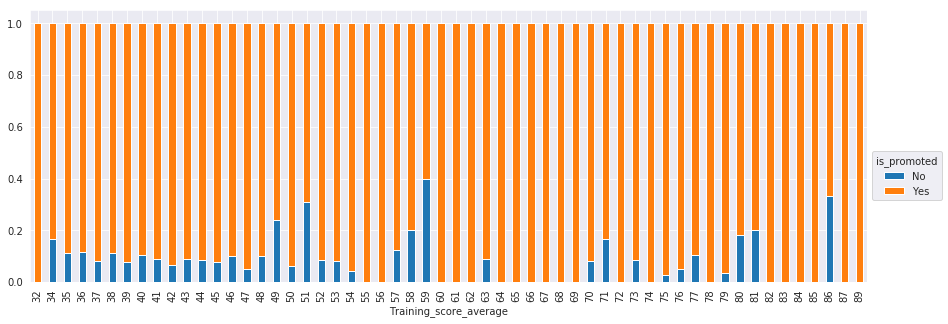

In [0]:
quali_null_data = training_data[training_data['Qualification'].isna()]

# plt.rcParams['figure.figsize'] = [10, 5]
# edu = pd.crosstab(quali_null_data.Qualification,quali_null_data.Foreign_schooled,normalize='index')
# edu.plot.bar(stacked=True)
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.legend(title='Foreign_schooled',bbox_to_anchor=(1,0.5))

plt.rcParams['figure.figsize'] = [15, 5]
edu = pd.crosstab(quali_null_data.Training_score_average,quali_null_data.Foreign_schooled,normalize='index')
edu.plot.bar(stacked=True)
plt.rcParams['figure.figsize'] = [15, 5]
plt.legend(title='is_promoted',bbox_to_anchor=(1,0.5))

In [0]:
training_data['Qualification'].fillna(training_data['Qualification'].mode()[0], inplace=True)
test_data['Qualification'].fillna(test_data['Qualification'].mode()[0], inplace=True)

In [0]:
training_data['Qualification'].unique()

array(['MSc, MBA and PhD', 'First Degree or HND',
       'Non-University Education'], dtype=object)

In [0]:
#Abbreviating Words
training_data.head(1)

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0


In [0]:
training_data.select_dtypes(exclude=['int', 'float']).columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Gender',
       'Channel_of_Recruitment', 'State_Of_Origin', 'Foreign_schooled',
       'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers'],
      dtype='object')

In [0]:
training_data['Age'] = 2019 - training_data['Year_of_birth']
test_data['Age'] = 2019 - test_data['Year_of_birth']
training_data['service_years'] = 2019 - training_data['Year_of_recruitment']
test_data['service_years'] = 2019 - test_data['Year_of_recruitment']

In [0]:
#dropping Year_of_recruitment and Year_of_birth
training_data.drop('Year_of_recruitment', axis = 1, inplace = True)
test_data.drop('Year_of_recruitment', axis = 1, inplace = True)

training_data.drop('Year_of_birth', axis = 1, inplace = True)
test_data.drop('Year_of_birth', axis = 1, inplace = True)

In [0]:
def abbrevQua(io):
    values ={
      'MSc, MBA and PhD':'GRAD',
      'First Degree or HND':'COLLEGE',
      'Non-University Education':'CERT',
      'unknown': 'NON'
      }
    return values[io]
training_data['Qualification']=training_data['Qualification'].apply(abbrevQua)
test_data['Qualification']=test_data['Qualification'].apply(abbrevQua)
# training_data['Qualification'].value_counts()

In [0]:
training_data['Trainings_Attended'].value_counts(), training_data['Qualification'].value_counts(), training_data['service_years'].value_counts()

(2     30981
 3      5631
 4      1244
 5       316
 6        93
 7        28
 8         6
 10        5
 11        4
 9         4
 Name: Trainings_Attended, dtype: int64, COLLEGE    27257
 GRAD       10469
 CERT         586
 Name: Qualification, dtype: int64, 3     4916
 4     4757
 2     4656
 5     4101
 7     3909
 6     3314
 1     3194
 8     2011
 9     1865
 10    1497
 11     619
 12     570
 13     472
 15     422
 16     394
 14     376
 17     293
 18     269
 19     230
 20      90
 21      53
 24      51
 23      46
 22      38
 25      35
 26      27
 29      22
 28      21
 27      20
 31      13
 30      11
 32       8
 33       7
 34       4
 37       1
 Name: service_years, dtype: int64)

In [0]:
# import seaborn as sns
# sns.set(style="ticks")

# sns.pairplot(training_data, hue="Promoted_or_Not")

In [0]:
# # sns.catplot(x="service_years", y="Qualification", hue="Promoted_or_Not", kind="swarm", data=training_data);

# sns.catplot(x="service_years", y="Qualification", hue="Promoted_or_Not", kind="swarm", data=training_data[training_data['service_years'] > 1]);

**FEAUTURE ENGINEERING**

In [0]:
# Growth Level
# Service Years: 1-20, >21
# num_trainings: 2-7, >7
# degrees: GRAD, COLLEGE, CERT
    
    
# Growth Level
# Company Years: <=10, 10-19, >19
# num_trainings: =2, 3-5, >=7
# degrees: GRAD, COLLEGE, CERT

def Growth_Level(service_years, num_trainings):
    if num_trainings >=7 and service_years > 19:
        return 5
    if num_trainings >2 and service_years > 10:
        return 4
    if num_trainings >=3 and service_years > 10:
        return 3
    if num_trainings <=2 and service_years <=10:
        return 2
    else:
        return 1

def Diminishing_Level(service_years, age, last_performance_score):
    if age > 35 and last_performance_score < 7 and service_years > 18:
        return 4
    if age <= 25 and last_performance_score < 7 and service_years < 10:
        return 3
    if age > 25 and last_performance_score < 7 and service_years > 15:
        return 2
    else:
        return 1
    
def Nagativity_Level(past_errors, target_met, last_performance_score):
    if past_errors == 'Yes' and target_met == '0' and last_performance_score < 3:
        return 4
    if past_errors == 'Yes' and target_met == '0' and last_performance_score <= 7.5:
        return 3
    if past_errors == 'Yes' and target_met == '0' and last_performance_score < 13:
        return 2
    else:
        return 1
    
def Uni_Level(Foreign_schooled, degrees):
    if Foreign_schooled == 'Yes' and degrees == 'GRAD':
        return 5
    if Foreign_schooled == 'Yes' and degrees == 'COLLEGE':
        return 4
    if Foreign_schooled == 'No' and degrees == 'GRAD':
        return 3
    if Foreign_schooled == 'No' and degrees == 'COLLEGE':
        return 2
    else:
        return 1


In [0]:
training_data['Growth_Level']=training_data.apply(lambda x:Growth_Level(x['service_years'],x['Trainings_Attended']),axis=1)
test_data['Growth_Level']=test_data.apply(lambda x:Growth_Level(x['service_years'],x['Trainings_Attended']),axis=1)

# training_data['Diminishing_Level']=training_data.apply(lambda x:Diminishing_Level(x['service_years'],x['Age'], x['Last_performance_score']),axis=1)
# test_data['Diminishing_Level']=test_data.apply(lambda x:Diminishing_Level(x['service_years'],x['Age'], x['Last_performance_score']),axis=1)

training_data['Nagativity_Level']=training_data.apply(lambda x:Nagativity_Level(x['Past_Disciplinary_Action'],x['Targets_met'], x['Last_performance_score']),axis=1)
test_data['Nagativity_Level']=test_data.apply(lambda x:Nagativity_Level(x['Past_Disciplinary_Action'],x['Targets_met'], x['Last_performance_score']),axis=1)

training_data['Uni_Level']=training_data.apply(lambda x:Uni_Level(x['Foreign_schooled'],x['Qualification']),axis=1)
test_data['Uni_Level']=test_data.apply(lambda x:Uni_Level(x['Foreign_schooled'],x['Qualification']),axis=1)

In [0]:
training_data.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Age,service_years,Growth_Level,Nagativity_Level,Uni_Level
0,YAK/S/00001,Commercial Sales and Marketing,GRAD,Female,Direct Internal process,2,12.5,1,0,41,ANAMBRA,No,Married,No,No,0,0,33,8,2,1,3
1,YAK/S/00002,Customer Support and Field Operations,COLLEGE,Male,Agency and others,2,12.5,0,0,52,ANAMBRA,Yes,Married,No,No,0,0,28,4,2,1,4
2,YAK/S/00003,Commercial Sales and Marketing,COLLEGE,Male,Direct Internal process,2,7.5,0,0,42,KATSINA,Yes,Married,No,No,0,0,32,7,2,1,4
3,YAK/S/00004,Commercial Sales and Marketing,COLLEGE,Male,Agency and others,3,2.5,0,0,42,NIGER,Yes,Single,No,No,1,0,37,10,1,1,4
4,YAK/S/00006,Information and Strategy,COLLEGE,Male,Direct Internal process,3,7.5,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0,29,7,1,1,4


In [0]:
# training_data['Growth_Level'].value_counts()

In [0]:
training_data['State_Of_Origin'].value_counts()

LAGOS          6204
FCT            2389
OGUN           2302
RIVERS         2222
ANAMBRA        1710
KANO           1649
DELTA          1594
OYO            1508
KADUNA         1399
IMO            1307
EDO            1259
ENUGU          1025
ABIA            950
OSUN            929
ONDO            875
NIGER           857
KWARA           765
PLATEAU         739
AKWA IBOM       673
NASSARAWA       632
KATSINA         615
ADAMAWA         605
BENUE           579
BAUCHI          557
KOGI            542
SOKOTO          499
CROSS RIVER     495
EKITI           455
BORNO           447
TARABA          400
KEBBI           393
BAYELSA         324
EBONYI          313
GOMBE           291
ZAMFARA         290
JIGAWA          262
YOBE            257
Name: State_Of_Origin, dtype: int64

In [0]:
#categorized into six geo-political zones
def groupStates(io):
    state={
      'KWARA':'NC','NASSARAWA':'NC','KOGI':'NC','NIGER':'NC','BENUE':'NC','PLATEAU':'NC','FCT':'NC',
      'BORNO':'NE','GOMBE':'NE','TARABA':'NE','YOBE':'NE','ADAMAWA':'NE','BAUCHI':'NE',
      'ZAMFARA':'NW','JIGAWA':'NW','KATSINA':'NW','KANO':'NW','KEBBI':'NW','KADUNA':'NW','SOKOTO':'NW',
      'ABIA':'SE','ENUGU':'SE','EBONYI':'SE','IMO':'SE','ANAMBRA':'SE',
      'BAYELSA':'SS','AKWA IBOM':'SS','RIVERS':'SS','DELTA':'SS','EDO':'SS','CROSS RIVER':'SS',  
      'LAGOS':'SW','OYO':'SW','OSUN':'SW','EKITI':'SW','OGUN':'SW','ONDO':'SW',
      }
    return state[io]

#one hot encode
training_data['State_Of_Origin'] = training_data['State_Of_Origin'].apply(groupStates)
test_data['State_Of_Origin'] = test_data['State_Of_Origin'].apply(groupStates)

In [0]:
training_data['State_Of_Origin'].value_counts()

SW    12273
SS     6567
NC     6503
SE     5305
NW     5107
NE     2557
Name: State_Of_Origin, dtype: int64

In [0]:
# plt.rcParams['figure.figsize'] = [14, 5]
# sns.scatterplot(x='age',y='Training_score_average',hue='Promoted_or_Not',data=training_data)

In [0]:
training_data['No_of_previous_employers'] = training_data['No_of_previous_employers'].apply(lambda x: '7' if x == 'More than 5' else x)
test_data['No_of_previous_employers'] = test_data['No_of_previous_employers'].apply(lambda x: '7' if x == 'More than 5' else x)
training_data['No_of_previous_employers'].value_counts()

1    18867
0    13272
2     1918
3     1587
4     1324
5      943
7      401
Name: No_of_previous_employers, dtype: int64

In [0]:
test_data['Last_performance_score']=test_data['Last_performance_score'].round().astype('category')

In [0]:
categorical = ['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers',
 'Last_performance_score']

In [0]:
#LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in categorical :
    training_data[column] = le.fit_transform(training_data[column])
    

for column in categorical :
    test_data[column] = le.fit_transform(test_data[column])
    

In [0]:
training_data.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Age,service_years,Growth_Level,Nagativity_Level,Uni_Level
0,YAK/S/00001,1,2,0,1,2,5,1,0,41,3,0,0,0,0,0,0,33,8,2,1,3
1,YAK/S/00002,2,1,1,0,2,5,0,0,52,3,1,0,0,0,0,0,28,4,2,1,4
2,YAK/S/00003,1,1,1,1,2,3,0,0,42,2,1,0,0,0,0,0,32,7,2,1,4
3,YAK/S/00004,1,1,1,0,3,1,0,0,42,0,1,2,0,0,1,0,37,10,1,1,4
4,YAK/S/00006,4,1,1,1,3,3,0,0,77,4,1,0,0,0,1,0,29,7,1,1,4


In [0]:
training_data_num = training_data['EmployeeNo']
test_data_num = test_data['EmployeeNo']

training_data.drop("EmployeeNo", axis = 1, inplace = True)
test_data.drop("EmployeeNo", axis = 1, inplace = True)

In [0]:
#save and drop the target varriable
y_train=training_data['Promoted_or_Not']
training_data.drop('Promoted_or_Not',axis=1,inplace=True)

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


x_trn,x_valid, y_trn, y_valid = train_test_split(training_data,y_train, test_size = 0.2, random_state = 42)

In [0]:
#parameter tuning
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# model_xg =XGBClassifier()
# param_dist = {"max_depth": [6,7,8],
#               "min_child_weight" : [7,8,9],
#               "n_estimators": [140],
#               "learning_rate": [0.08, 0.10, 0.11],
#               "gamma":[0.0, 0.03, 0.05]}
# grid_search = GridSearchCV(model_xg, param_grid=param_dist, cv = 3, 
#                                    verbose=10, n_jobs=-1)
# grid_search.fit(training_data, y_train)

# grid_search.best_estimator_

In [0]:
#Applying XGboost
model_xg =XGBClassifier(objective="binary:logistic", 
    learning_rate=0.1, 
    min_child_weight=7,
    max_depth=7, 
    gamma=0, 
    n_estimators=200)
model_xg.fit(training_data,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#Our Score on Validation Data
model_xg.score(x_valid,y_valid)
#0.9425812345034582

0.9427117316977685

In [0]:
#Prediction on Test Set
predict_y_xg = model_xg.predict(test_data)

In [0]:
#Our Score on Training data
model_xg.score(x_trn,y_trn)
#0.9485464452347548

0.9484485627589807

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_data_num, 'Promoted_or_Not': predict_y_xg })
my_submission.to_csv('submission_samuel.csv', index=False)

In [0]:
!kaggle competitions submit -c intercampusai2019 -f submission_samuel.csv -m "DSN_FILE"

100% 226k/226k [00:01<00:00, 117kB/s]
Successfully submitted to Data Science Nigeria Staff Promotion Algorithm 

In [0]:
!kaggle competitions submissions -c intercampusai2019

fileName               date                 description  status    publicScore  privateScore  
---------------------  -------------------  -----------  --------  -----------  ------------  
submission_samuel.csv  2019-10-24 05:14:22  DSN_FILE     pending   None         None          
submission_samuel.csv  2019-10-24 05:13:13  DSN_FILE     complete  0.94320      0.93782       
submission_samuel.csv  2019-10-24 05:11:28  DSN_FILE     complete  0.94482      0.93869       
submission_samuel.csv  2019-10-23 19:39:06  DSN_FILE     complete  0.94543      0.93955       
submission_samuel.csv  2019-10-23 19:36:57  DSN_FILE     complete  0.94543      0.93955       
submission_samuel.csv  2019-10-23 19:14:28  DSN_FILE     complete  0.94664      0.93929       
submission_samuel.csv  2019-10-23 16:24:32  DSN_FILE     complete  0.94583      0.93903       
submission_samuel.csv  2019-10-23 16:09:54  DSN_FILE     complete  0.94664      0.93929       
submission_samuel.csv  2019-10-23 16:08:53  DSN_FI

In [0]:
files.download('submission_samuel.csv')